# SCI6485 Introduction to Generative Artificial Intelligence

##  Variational Autoencoder


**Harvard University**<br/>
**Fall 2023**<br/>
**Instructor:**  Sabrina Osmany<br/>
**TA:**  Jiabin Wei<br/>

**DISCLAIMER**: No public reproduction of this code is allowed without the explicit consent of their authors.

<hr style="height:2pt">

---

In [ ]:
import torch
# make the code reproducible
torch.backends.cudnn.deterministic = True
torch.manual_seed(1)
torch.cuda.manual_seed(1)

# Load data

As in the previous tutorials, the Variational Autoencoder is implemented and trained on the MNIST dataset.

In [ ]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd
import random
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

100%|██████████| 9912422/9912422 [00:00<00:00, 111506379.81it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 89465061.91it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32161551.54it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22733327.89it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



torch.Size([256, 1, 28, 28])


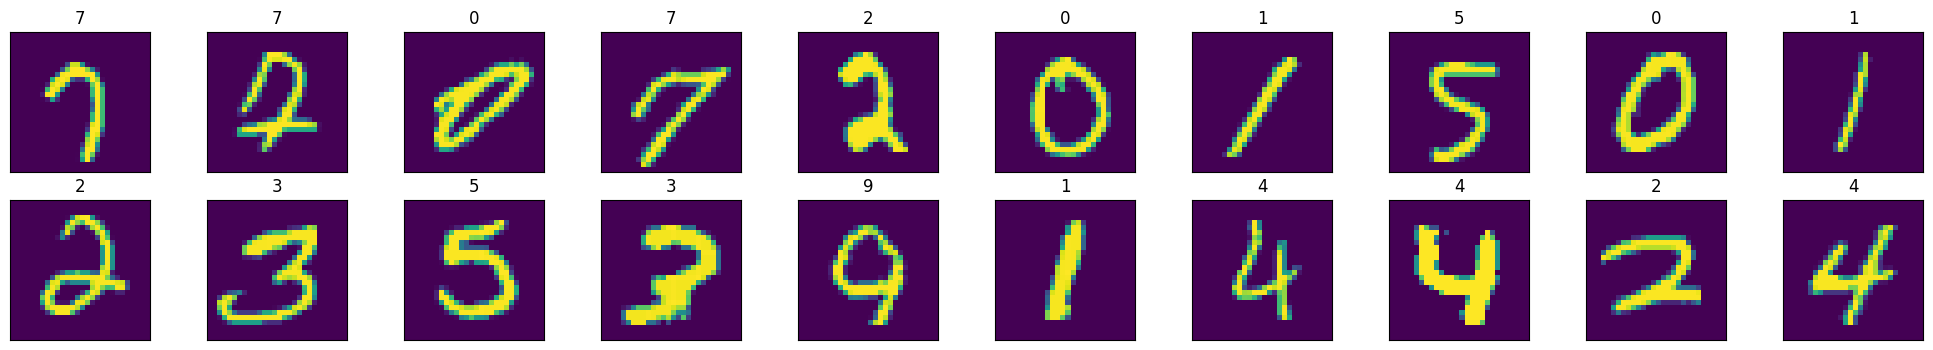

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def im_convert(img):
    npimg = img.numpy()
    image = np.transpose(npimg, (1, 2, 0))
    return image

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# check batch size
print(images.shape)

# show images
fig = plt.figure(figsize=(25, 4))
# We plot 20 images from our train_dataset
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx])) #converting to numpy array as plt needs it.
  ax.set_title(classes[labels[idx].item()])

# Build VAE

## Encoder
Now, we define a VariationalAutoencoder class, which combines the Encoder and Decoder classes [3].
The encoder and decoder networks contain three convolutional layers and two fully connected layers. Some batch normal layers are added to have more robust features in the latent space. Differently from the standard autoencoder, the encoder returns mean and variance matrices and we use them to obtain the sampled latent vector. In the VariationalEncoder class, we obtain the Kullback-Leibler term.

In [ ]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims, device, in_channels=1):
        super(VariationalEncoder, self).__init__()

        self.fc1 = nn.Linear(28*28*1, 1500)
        self.fc2_mu = nn.Linear(1500, latent_dims)
        self.fc2_logvar = nn.Linear(1500, latent_dims)
        self.relu = nn.LeakyReLU()

        # variable to store Kullback–Leibler (KL) divergence
        self.kl = 0

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = x.to(device)
        x = self.relu(self.fc1(x))

        # 1) The encoder produces a mean value (mu) for each dimension of the latent space, which represents the center of a Gaussian distribution in that dimension.
        mu =  self.fc2_mu(x)
        # 2) The encoder also produces a log-variance value (logvar) for each dimension, which is often treated as a learned offset to the Gaussian's log-variance.
        logvar = self.fc2_logvar(x)
        # It's common to work with the logarithm of the variance (log-variance) rather than the standard deviation (sigma) directly
        # reason 1: the log-variance can take on any real value, which is important because it allows the model to capture both small and large variances effectively.
        # reason 2: optimization algorithms like gradient descent often beneficial to work with quantities that are centered around zero. Taking the logarithm helps center the values around zero and avoids issues with extremely small or large numbers.

        # 3) During the sampling process (when generating latent vectors), you exponentiate the logvar to obtain the standard deviation (sigma) of the Gaussian distribution.
        std = torch.exp(0.5 *logvar)

        # 4) You then sample from this Gaussian distribution with mean (mu) and standard deviation (sigma) to generate a latent vector.
        # a latent vector is sampled from this probability distribution
        # Each element of eps will be a random value sampled from a standard normal distribution (mean 0, standard deviation 1)
        eps = torch.randn_like(std)
        z = eps.mul(std).add_(mu)

        # add an auxillary loss that penalizes the distribution P(z|x) for being to far from the N(0,1)
        # Kullback–Leibler (KL) divergence: https://stats.stackexchange.com/questions/500110/clarification-of-variational-autoencoders
        # reason 1: we need this loss to train the encoder network since gradients cannot flow through sampling (which is a non-differentiable operation).
        # reason 2: we can encourage the latent vectors to occupy a more centralized and uniform location by penalizing the KL divergence
        # we could also approximate KL with monte-carlo simulation. The code is shown below.

        self.kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return z

In [ ]:
#######################################################
#        skip this code
#######################################################
def kl_divergence(self, z, mu, sigma):
    # --------------------------
    # Monte carlo KL divergence
    # --------------------------
    # 1. define the first two probabilities (in this case Normal for both)
    p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(sigma))
    q = torch.distributions.Normal(mu, sigma)

    # 2. get the probabilities from the equation
    log_qzx = q.log_prob(z)
    log_pz = p.log_prob(z)

    # kl
    kl = (log_qzx - log_pz)

    # sum over last dim to go from single dim distribution to multi-dim
    kl = kl.sum(-1)
    return kl

## Decoder
After we define the Decoder class, which remains the same as the one I showed in the fifth tutorial of the series.

In [ ]:
class Decoder(nn.Module):

    def __init__(self, latent_dims, in_channels=1):
        super().__init__()
        # Decoder Linear Layers
        self.fc3 = nn.Linear(latent_dims, 1500)
        self.fc4 = nn.Linear(1500, 28*28*1)
        self.relu = nn.LeakyReLU()


    def forward(self, x):
        x = self.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        x = x.view(-1, 1, 28, 28)


        return x

## Connecrt encoder and decoder
Below, we define the class that merges the encoder and decoder:

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims, device, in_channels=1):
        super(VariationalAutoencoder, self).__init__()
        # Instantiate the Encoder
        self.encoder = VariationalEncoder(latent_dims, device, in_channels=in_channels)
        # Instantiate the Decoder
        self.decoder = Decoder(latent_dims, in_channels=in_channels)

    def forward(self, x):
        x = x.to(device)
        # Encode the input tensor to obtain a latent vector
        z = self.encoder(x)
        # Decode the latent vector to reconstruct the input
        return self.decoder(z)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

latent_dim = 4
in_channals = 1

vae = VariationalAutoencoder(latent_dims=latent_dim, device=device, in_channels=in_channals)

lr = 1e-3

optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

vae.to(device)

Selected device: cuda


VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (fc1): Linear(in_features=784, out_features=1500, bias=True)
    (fc2_mu): Linear(in_features=1500, out_features=4, bias=True)
    (fc2_logvar): Linear(in_features=1500, out_features=4, bias=True)
    (relu): LeakyReLU(negative_slope=0.01)
  )
  (decoder): Decoder(
    (fc3): Linear(in_features=4, out_features=1500, bias=True)
    (fc4): Linear(in_features=1500, out_features=784, bias=True)
    (relu): LeakyReLU(negative_slope=0.01)
  )
)

# Train and test the model

## define training and validation function

We define the functions to train and evaluate the Variational Autoencoder:

In [ ]:
### Training function
def train_epoch(vae, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader:
        # Move tensor to the proper device
        x = x.to(device)
        # This line passes the input data x through the VAE model (vae) to obtain the reconstructed data x_hat
        # The VAE performs both encoding and decoding operations in this step
        x_hat = vae(x)

        # Evaluate loss：
        # the binary cross-entropy loss is calculated to measure the dissimilarity between the reconstructed data x_hat and the original input data x
        # This loss quantifies how well the VAE is able to reconstruct the input data
        reconstruction_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
        # The total loss for the batch is computed as the sum of the reconstruction loss and the Kullback-Leibler (KL) divergence term
        loss = reconstruction_loss + vae.encoder.kl

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

Validation dataset is a new concept. It is useful to introduce the concept here as we already encounter the overfitting problem in the last HW. Overfitting occurs when a model becomes too specialized in learning the training data, to the detriment of its ability to generalize to new, unseen data.

One of the purposes to have a validation dataset during the training process is that by evaluating a model's performance on the validation dataset, you can detect signs of overfitting and adopt some techniques to avoid this problem before evaluating the model on testing dataset.  If the model performs well on the training data but poorly on the validation data, it's an indication that the model may be overfitting.

In [ ]:
### Testing function
def test_epoch(vae, device, dataloader):
    # Set evaluation mode for encoder and decoder
    # This means that any layers within the VAE, such as dropout or batch normalization layers, will now operate in their deterministic mode
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)

            # This loss quantifies how well the VAE is able to reconstruct the input data
            reconstruction_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
            # The total loss for the batch is computed as the sum of the reconstruction loss and the Kullback-Leibler (KL) divergence term
            loss = reconstruction_loss + vae.encoder.kl

            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

## Train the model

creat two lists to store the training history

In [ ]:
training_loss_history = []
validation_loss_history = []

In [ ]:
# plot the original images and the recontructed images during the training process
def plot_gallery(images, h, w, n_row=3, n_col=6, with_title=False, titles=[]):
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(im_convert(images[i].reshape((1, h, w))))
            if with_title:
                plt.title(titles[i])
            plt.xticks(())
            plt.yticks(())
        except:
            pass


 EPOCH 1/5 	 train loss 173.710 	 val loss 146.893

 EPOCH 2/5 	 train loss 143.684 	 val loss 141.119

 EPOCH 3/5 	 train loss 139.724 	 val loss 138.354

 EPOCH 4/5 	 train loss 137.491 	 val loss 136.677

 EPOCH 5/5 	 train loss 135.963 	 val loss 135.544


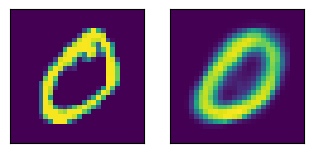

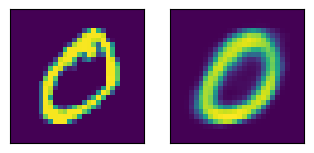

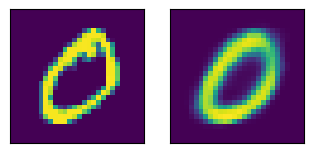

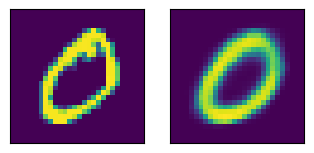

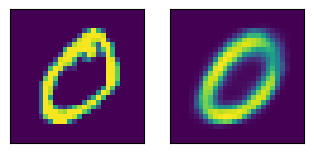

In [ ]:
num_epochs = 5

for epoch in range(num_epochs):
    train_loss = train_epoch(vae, device, train_loader, optim)
    val_loss = test_epoch(vae, device, valid_loader)
    training_loss_history.append(train_loss)
    validation_loss_history.append(val_loss)

    # show an exmaple of reconstructed image
    with torch.set_grad_enabled(False):
        pic_input = train_dataset[1][0].unsqueeze(0).to(device)
        pic_output  = vae.decoder(vae.encoder(pic_input))
        pic_output = pic_output[0].squeeze()
        pic_output = pic_output.to("cpu")
        pic_input = pic_input.to("cpu")
        plot_gallery([pic_input, pic_output],28,28,1,2)

    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))



plot the loss curve

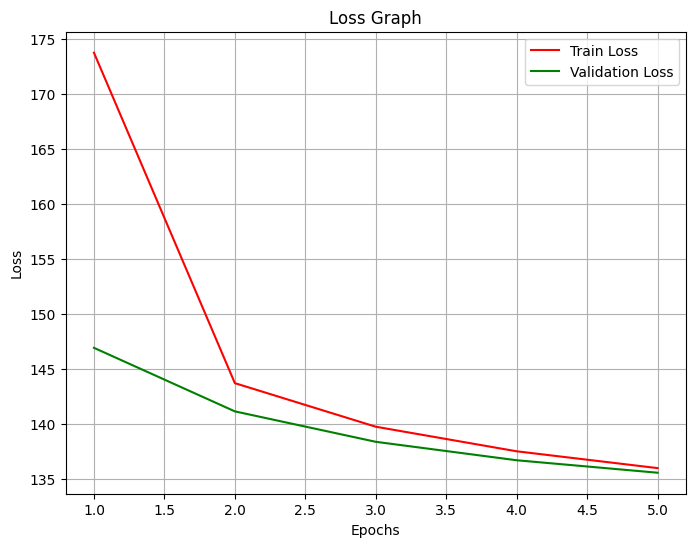

In [ ]:
# plot the losss curve
epochs = list(range(1, len(training_loss_history) + 1))
# Create a single figure and axis for both curves
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the training loss curve in red
plt.plot(epochs, training_loss_history, color='r', label='Train Loss')

# Plot the validation loss curve in green
plt.plot(epochs, validation_loss_history, color='g', label='Validation Loss')

# Set the title, labels, and legend
plt.title('Loss Graph')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Add a grid
ax.grid(True)

# Show the plot
plt.show()

In [ ]:
PATH = './minst_VAE.pth'
torch.save(vae.state_dict(), PATH)

# Visualize the reconstructed images and generate new images

## Visualize the reconstructed images
I am also interested to see the input and its corresponding reconstruction in each epoch during the training of the VAE model. For this reason, I define a function to have these visualizations:

In [ ]:
def plot_ae_outputs(encoder, decoder, n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.tolist()
    t_idx = []
    for i in range(n):
      t_idx.append(targets.index(i))

    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      # plt.imshow(img.cpu().squeeze().numpy().transpose(1, 2, 0))
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
      # plt.imshow(rec_img.cpu().squeeze().numpy().transpose(1, 2, 0))
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()

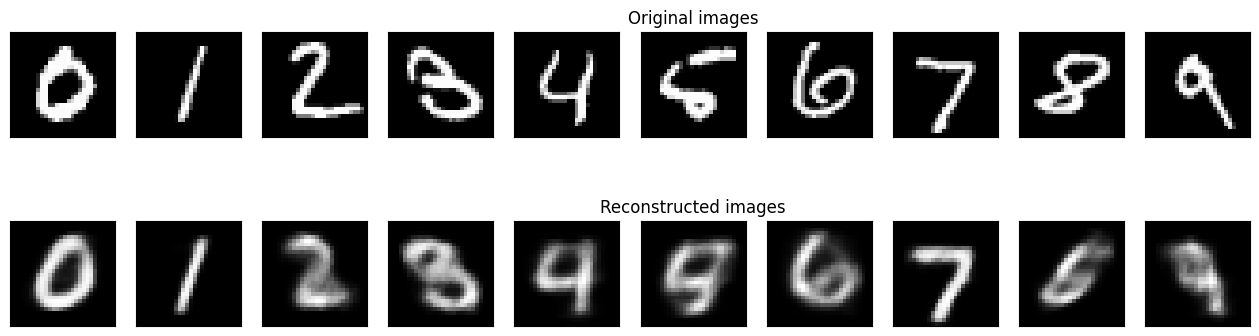

In [ ]:
plot_ae_outputs(vae.encoder, vae.decoder, n=len(classes))

## Generate new images

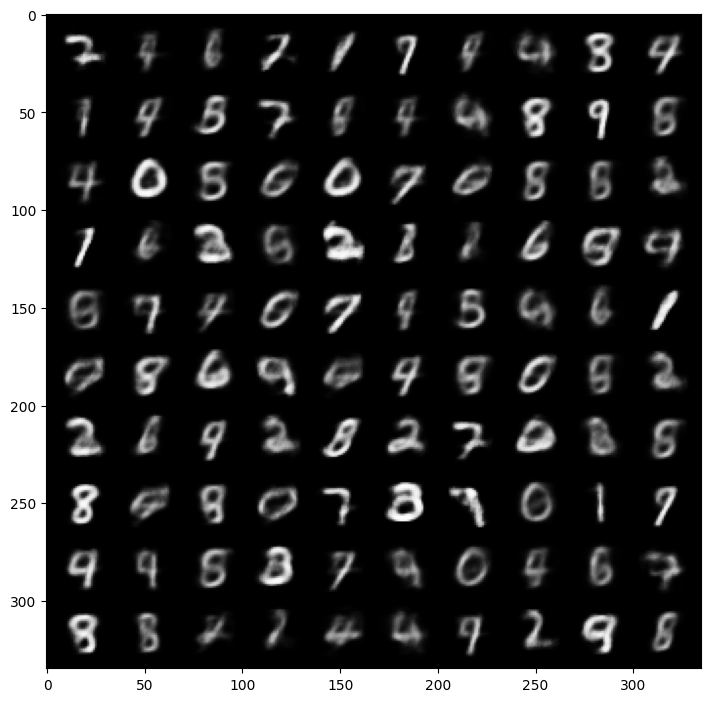

In [ ]:
def show_image(img):
    npimg = img.numpy()
    #  transposes the dimensions of the NumPy array to convert it from a PyTorch tensor format (C, H, W) to a Matplotlib format (H, W, C)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# sets the VAE model to evaluation mode
vae.eval()

#  temporarily disable gradient computation
with torch.no_grad():

    # sample latent vectors from the normal distribution
    # 100 random latent vectors are sampled from a standard normal distribution
    # These latent vectors will be used to generate reconstructed images
    latent = torch.randn(100, latent_dim, device=device)

    # reconstruct images from the latent vectors
    img_recon = vae.decoder(latent)
    # After generating the reconstructed images, the data is moved to the CPU. This is often done for compatibility with Matplotlib for visualization.
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
    plt.show()

## (optional) Visualize the latent space

In [ ]:
from tqdm import tqdm
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    vae.eval()
    with torch.no_grad():
        encoded_img  = vae.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples


import plotly.express as px
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)


100%|██████████| 10000/10000 [00:07<00:00, 1301.81it/s]


In [ ]:
# we could also visualize the latent space with the embedding projector: https://projector.tensorflow.org
# saving as tsv file
encoded_samples.to_csv('encoding_latent_layer.tsv', sep="\t", index=False)

A better visualization can be obtained by applying the t-SNE, a reduction dimensionality method. With two components, I can visualize the latent code:

In [ ]:
import sklearn
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

# RGB images

## Load data

### Read CIFAR10 data

In [ ]:
data_dir = 'dataset'
batch_size = 64
resize_img = 28

# set the transform function
transform = transforms.Compose([
                              transforms.Resize(size=resize_img),
                              transforms.ToTensor(),
                              # Normalize all channel values to [0,1]
                              transforms.Normalize((0, 0, 0), (1, 1, 1))
                              ])

# get training dataset and save the image to your colab root directory
train_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=True,
                                        download=True, transform=transform)
# get testing dataset and save the image to your colab root directory
test_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=False,
                                       download=True, transform=transform)



classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# we only use one category to train the VAE. The number below indicates the index of the category in the class list
selected_classes = [1,]

# Filter the dataset to keep only the selected classes
train_dataset.data = [x for i, x in enumerate(train_dataset.data) if train_dataset.targets[i] in selected_classes]
train_dataset.targets = [y for y in train_dataset.targets if y in selected_classes]

# split to get train data and validation data
m=len(train_dataset)
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


# Filter the dataset to keep only the selected classes
test_dataset.data = [x for i, x in enumerate(test_dataset.data) if test_dataset.targets[i] in selected_classes]
test_dataset.targets = [y for y in test_dataset.targets if y in selected_classes]

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

print(len(train_data))
print(len(val_data))
print(len(test_dataset))

# subset_size = 20000
# # Create a random sampler to select a subset of the dataset
# subset_sampler = torch.utils.data.RandomSampler(trainset, num_samples=subset_size, replacement=False)

# # Use a DataLoader with the sampler to load the subset
# subset_loader = torch.utils.data.DataLoader(subset_sampler, batch_size=batch_size, sampler=subset_sampler)



Files already downloaded and verified
Files already downloaded and verified
4000
1000
1000


torch.Size([64, 3, 28, 28])


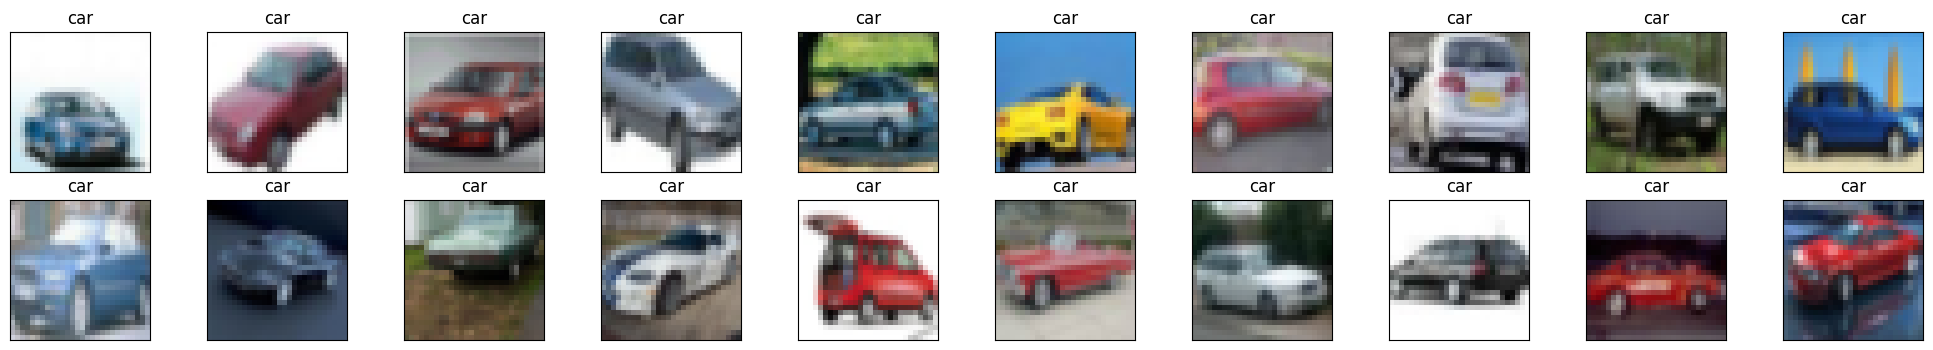

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def im_convert(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    image = np.transpose(npimg, (1, 2, 0))
    return image

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# check batch size
print(images.shape)

# show images
fig = plt.figure(figsize=(25, 4))
# We plot 20 images from our train_dataset
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx])) #converting to numpy array as plt needs it.
    ax.set_title(classes[labels[idx].item()])

### Load custom dataset

In [ ]:
#######################################################
# Option_1: upload your dataset zip file to the colab `content` folder. If you upload the folder directory, then skip this step
#######################################################
!unzip rome_weather.zip
# use this line if you want to unzip it to a specific folder
# !unzip data.zip -d your_specific_directory

unzip:  cannot find or open rome_weather.zip, rome_weather.zip.zip or rome_weather.zip.ZIP.


In [ ]:
#######################################################
# Option_2: mount your google dirve and access dataset in your drive folder
#######################################################
# Mount your google drive to colab conent directory
from google.colab import drive
drive.mount('/content/drive/')

# set the folder where your store your dataset as the root directory
import os
os.chdir('/content/drive/MyDrive/Fall23_GenAI/0926')

# This code will show your dataset folder and anything in the root directory you just set above
!ls

In [ ]:
import pandas as pd
import os
from PIL import Image


#######################################################
#               set your data directory
#######################################################
root_directory = "" # if you save the data to the current root directory, you can leave this variable as it is
dataset_path = root_directory + "rome_weather/"

#######################################################
#             set your data class list
#######################################################
# set your image labels. The class name should be the same as the class folder name under your dataset directory
class_list = ['Cloudy', 'Foggy', 'Rainy', 'Snowy', 'Sunny']
selected_classes = [0,]

# we generate a dataframe to store all your image pathes and the corresponding labels.
image_name_list = []
image_label = []
print(os.listdir("/"))
for class_name in os.listdir(dataset_path):
    if not class_name.startswith('.'):
        for idx, image in enumerate(os.listdir(dataset_path + class_name + '/')):
            if not image.startswith('.'):
                image_name_list.append(dataset_path + class_name + '/' + image)
                image_label.append(class_name)

dataset_df = pd.DataFrame(columns=["img_name","label"])
dataset_df["img_name"] = image_name_list
dataset_df["label"] = image_label


#######################################################
#                 set your csv name
#######################################################
#    we save the dataframe as a csv file and save it to the root directory of colab
csv_name = 'dataset_csv.csv'
dataset_df.to_csv (root_directory + csv_name, index = False, header=True)
print(dataset_df)

['proc', 'boot', 'srv', 'root', 'usr', 'run', 'tmp', 'etc', 'opt', 'lib', 'lib64', 'dev', 'media', 'home', 'mnt', 'sbin', 'bin', 'sys', 'libx32', 'var', 'lib32', 'content', '.dockerenv', 'datalab', 'tools', 'python-apt', 'NGC-DL-CONTAINER-LICENSE', 'cuda-keyring_1.0-1_all.deb']


FileNotFoundError: ignored

In [ ]:
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class CustomeDataset(Dataset):
    def __init__(self, root_dir, annotation_file, class_list, subclass_list=None, transform=None):
        self.root_dir = root_dir
        if subclass_list is not None:
            # Use list comprehension to get the corresponding items
            selected_items = [class_list[i] for i in subclass_list]
            csv_df = pd.read_csv(annotation_file)
            self.annotations = csv_df[csv_df['label'].isin(selected_items)]
        else:
            self.annotations = pd.read_csv(annotation_file)
        self.class_list = class_list
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        image_id = self.annotations.iloc[index, 0]
        image = Image.open(os.path.join(self.root_dir, image_id)).convert("RGB")
        label = self.class_list.index(self.annotations.iloc[index, 1])

        if self.transform is not None:
            image = self.transform(image)

        return (image, label)


#######################################################
#        set the image size for training
#######################################################
resize_img = 28

# This  transformation is used to create more data samples from your existng dataset.
# We will later add these transformed samples to the dataset to increase the total number of samples for training.
# This is called data augmentation
transform = transforms.Compose([
                              # set the height or width (which one is smaller) to 100 (the aspect ratio stays the same)
                              transforms.Resize(size=resize_img),
                              # crop the image from the centroid and resize them to 100*100
                              transforms.CenterCrop((resize_img,resize_img)),
                              transforms.ToTensor(),
                              # Normalize all channel values to [0,1]
                              transforms.Normalize((0, 0, 0), (1, 1, 1))
                              ])


# create your custom Pytorch dataset
dataset = CustomeDataset(root_directory, root_directory + csv_name, class_list, subclass_list=selected_classes, transform=transform)
print(len(dataset))



NameError: ignored

In [ ]:
#######################################################
#        set some parameters to process the data
#######################################################
# load dataset
batch_size = 32
train_percentage = 0.7
augmentation_train_dataset = True
augmentation_merge = True

# randomly split the dataset.
train_size = int(train_percentage * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset,[train_size, test_size])

# further split to get train data and validation data
m=len(train_dataset)
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

print(len(train_data))
print(len(val_data))
print(len(test_dataset))


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def im_convert(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    image = np.transpose(npimg, (1, 2, 0))
    return image

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# check batch size
print(images.shape)

# show images
fig = plt.figure(figsize=(25, 4))
# We plot 20 images from our train_dataset
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx])) #converting to numpy array as plt needs it.
    ax.set_title(classes[labels[idx].item()])

## Build VAE for rgb images

In [ ]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims, device, in_channels=1):
        super(VariationalEncoder, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, 32, 4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1)

        # This a batch normalization layer. it will improve training stability and convergence.
        # typically applied to individual layers after a linear transformation and before the activation function.
        self.batch2 = nn.BatchNorm2d(64)

        # Linear Layer for Mean (mu) of Latent Space
        self.linear_mu = nn.Linear(7*7*64, latent_dims)
        # Linear Layer for Log-Variance (logvar) of Latent Space
        self.linear_logvar = nn.Linear(7*7*64, latent_dims)

        self.relu = nn.ReLU()

        # variable to store Kullback–Leibler (KL) divergence
        self.kl = 0

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        # x = F.relu(self.batch2(self.conv2(x)))
        x = torch.flatten(x, start_dim=1)

        # 1) The encoder produces a mean value (mu) for each dimension of the latent space, which represents the center of a Gaussian distribution in that dimension.
        mu =  self.linear_mu(x)
        # 2) The encoder also produces a log-variance value (logvar) for each dimension, which is often treated as a learned offset to the Gaussian's log-variance.
        logvar = self.linear_logvar(x)
        # It's common to work with the logarithm of the variance (log-variance) rather than the standard deviation (sigma) directly
        # reason 1: the log-variance can take on any real value, which is important because it allows the model to capture both small and large variances effectively.
        # reason 2: optimization algorithms like gradient descent often beneficial to work with quantities that are centered around zero. Taking the logarithm helps center the values around zero and avoids issues with extremely small or large numbers.

        # 3) During the sampling process (when generating latent vectors), you exponentiate the logvar to obtain the standard deviation (sigma) of the Gaussian distribution.
        std = torch.exp(0.5 *logvar)

        # 4) You then sample from this Gaussian distribution with mean (mu) and standard deviation (sigma) to generate a latent vector.
        # a latent vector is sampled from this probability distribution
        # Each element of eps will be a random value sampled from a standard normal distribution (mean 0, standard deviation 1)
        eps = torch.randn_like(std)
        z = eps.mul(std).add_(mu)

        # add an auxillary loss that penalizes the distribution P(z|x) for being to far from the N(0,1)
        # Kullback–Leibler (KL) divergence. https://stats.stackexchange.com/questions/500110/clarification-of-variational-autoencoderss
        # reason 1: we need this loss to train the encoder network since gradients cannot flow through sampling (which is a non-differentiable operation).
        # reason 2: we can encourage the latent vectors to occupy a more centralized and uniform location by penalizing the KL divergence
        # we could also approximate KL with monte-carlo simulation. The code is shown below.

        self.kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return z

In [ ]:
class Decoder(nn.Module):

    def __init__(self, latent_dims, in_channels=1):
        super().__init__()

        self.decoder_lin = nn.Linear(latent_dims, 7 * 7 * 64)

        # reshape a flattened (1D) tensor into a multidimensional tensor
        # (64, 7, ,7) tuple representing the size of each dimension.
        # it specifies that the unflattened tensor should have a size of 32 along the first dimension and a size of 3x3 in the remaining dimensions.
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(64, 7, 7))

        # Decoder transpose convolutional Layers
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, in_channels, 4, stride=2, padding=1),
        )

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims, device, in_channels=1):
        super(VariationalAutoencoder, self).__init__()
        # Instantiate the Encoder
        self.encoder = VariationalEncoder(latent_dims, device, in_channels=in_channels)
        # Instantiate the Decoder
        self.decoder = Decoder(latent_dims, in_channels=in_channels)

    def forward(self, x):
        x = x.to(device)
        # Encode the input tensor to obtain a latent vector
        z = self.encoder(x)
        # Decode the latent vector to reconstruct the input
        return self.decoder(z)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

latent_dim = 30
in_channals = 3

vae_rgb = VariationalAutoencoder(latent_dims=latent_dim, device=device, in_channels=in_channals)

lr = 1e-3

optim = torch.optim.Adam(vae_rgb.parameters(), lr=lr, weight_decay=1e-5)

vae_rgb.to(device)

Selected device: cuda


VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear_mu): Linear(in_features=3136, out_features=30, bias=True)
    (linear_logvar): Linear(in_features=3136, out_features=30, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (decoder_lin): Linear(in_features=30, out_features=3136, bias=True)
    (unflatten): Unflatten(dim=1, unflattened_size=(64, 7, 7))
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
  )
)

## Train and test the model

In [ ]:
### Training function
def train_epoch(vae, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader:
        # Move tensor to the proper device
        x = x.to(device)
        # This line passes the input data x through the VAE model (vae) to obtain the reconstructed data x_hat
        # The VAE performs both encoding and decoding operations in this step
        x_hat = vae(x)

        # Evaluate loss：
        # the binary cross-entropy loss is calculated to measure the dissimilarity between the reconstructed data x_hat and the original input data x
        # This loss quantifies how well the VAE is able to reconstruct the input data
        reconstruction_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
        # reconstruction_loss = F.mse_loss(x_hat, x, reduction='sum')  # You can use other loss functions like SSIM
        # The total loss for the batch is computed as the sum of the reconstruction loss and the Kullback-Leibler (KL) divergence term
        loss = reconstruction_loss + vae.encoder.kl

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [ ]:
### Testing function
def test_epoch(vae, device, dataloader):
    # Set evaluation mode for encoder and decoder
    # This means that any layers within the VAE, such as dropout or batch normalization layers, will now operate in their deterministic mode
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)

            # This loss quantifies how well the VAE is able to reconstruct the input data
            reconstruction_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
            # reconstruction_loss = F.mse_loss(x_hat, x, reduction='sum')  # You can use other loss functions like SSIM
            # The total loss for the batch is computed as the sum of the reconstruction loss and the Kullback-Leibler (KL) divergence term
            loss = reconstruction_loss + vae.encoder.kl

            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [ ]:
# plot the original images and the recontructed images during the training process
def plot_gallery(images, h, w, n_row=3, n_col=6, with_title=False, titles=[]):
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(im_convert(images[i].reshape((3, h, w))))
            if with_title:
                plt.title(titles[i])
            plt.xticks(())
            plt.yticks(())
        except:
            pass

create two list to store the loss history

In [ ]:
training_loss_history = []
validation_loss_history = []


 EPOCH 1/10 	 train loss 1548.072 	 val loss 1450.189

 EPOCH 2/10 	 train loss 1436.501 	 val loss 1419.806

 EPOCH 3/10 	 train loss 1420.009 	 val loss 1409.489

 EPOCH 4/10 	 train loss 1409.420 	 val loss 1402.142

 EPOCH 5/10 	 train loss 1399.262 	 val loss 1396.075

 EPOCH 6/10 	 train loss 1394.154 	 val loss 1388.296

 EPOCH 7/10 	 train loss 1389.988 	 val loss 1385.178

 EPOCH 8/10 	 train loss 1388.034 	 val loss 1383.091

 EPOCH 9/10 	 train loss 1386.129 	 val loss 1382.120

 EPOCH 10/10 	 train loss 1384.709 	 val loss 1378.786


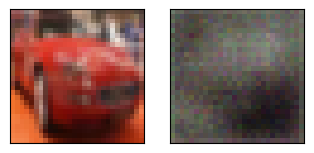

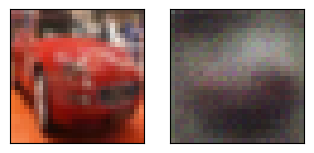

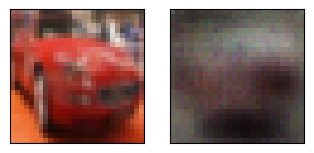

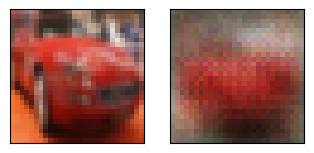

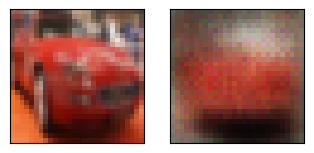

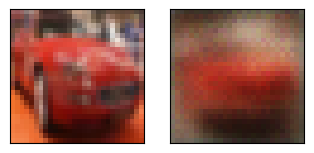

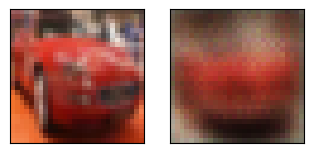

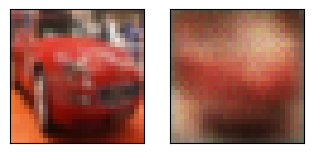

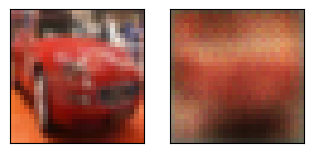

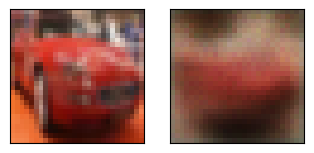

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    train_loss = train_epoch(vae_rgb, device, train_loader, optim)
    val_loss = test_epoch(vae_rgb, device, valid_loader)

    training_loss_history.append(train_loss)
    validation_loss_history.append(val_loss)

    # show an exmaple of reconstructed image
    with torch.set_grad_enabled(False):
        pic_input = train_dataset[1][0].unsqueeze(0).to(device)
        pic_output  = vae_rgb.decoder(vae_rgb.encoder(pic_input))
        pic_output = pic_output[0].squeeze()
        pic_output = pic_output.to("cpu")
        pic_input = pic_input.to("cpu")
        plot_gallery([pic_input, pic_output],28,28,1,2)

    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss, val_loss))


## Visualize the reconstructed images

In [ ]:
def plot_ae_outputs(encoder, decoder, n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets

    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[i][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      # plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      plt.imshow(im_convert(img.cpu().squeeze()))
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      # plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
      plt.imshow(im_convert(rec_img.cpu().squeeze()))
      # plt.imshow(rec_img.cpu().squeeze().numpy().transpose(1, 2, 0))
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()

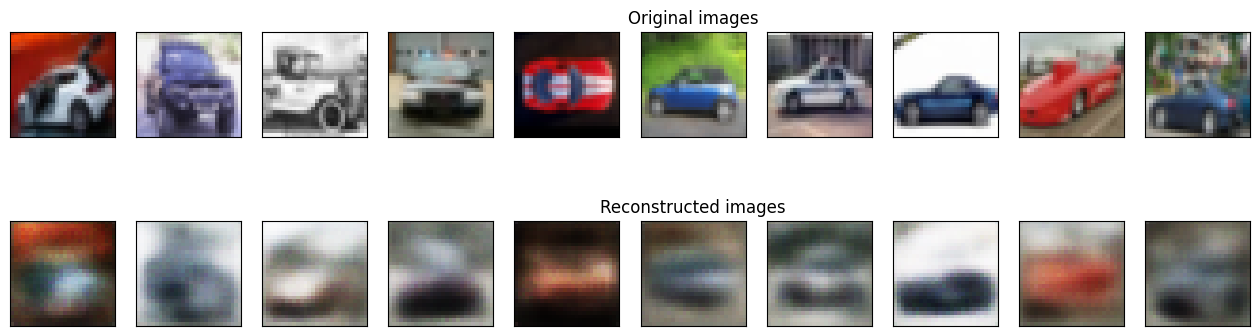

In [ ]:
plot_ae_outputs(vae_rgb.encoder, vae_rgb.decoder, n=10)

## Generate new images

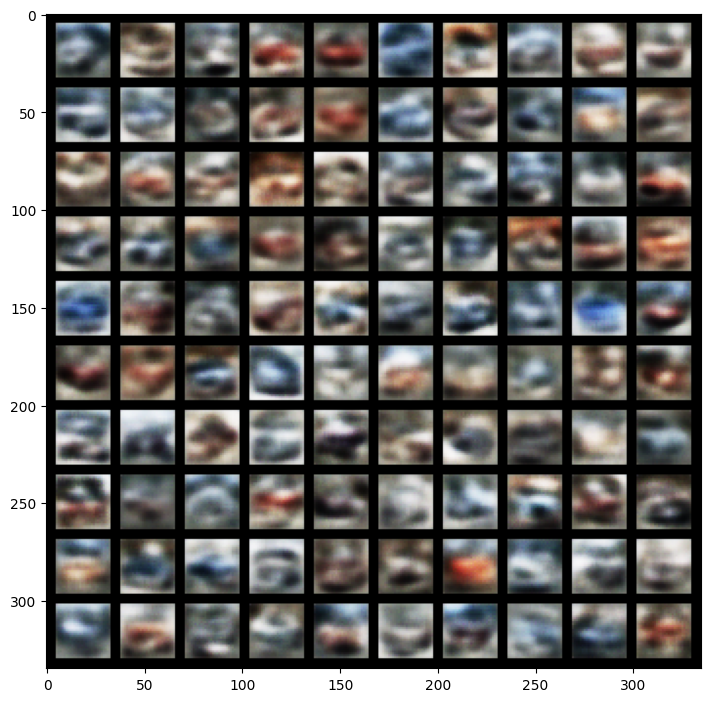

In [ ]:
def show_image(img):
    npimg = img.numpy()
    #  transposes the dimensions of the NumPy array to convert it from a PyTorch tensor format (C, H, W) to a Matplotlib format (H, W, C)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# sets the VAE model to evaluation mode
vae_rgb.eval()

#  temporarily disable gradient computation
with torch.no_grad():

    # sample latent vectors from the normal distribution
    # 100 random latent vectors are sampled from a standard normal distribution
    # These latent vectors will be used to generate reconstructed images
    latent = torch.randn(100, latent_dim, device=device)

    # reconstruct images from the latent vectors
    img_recon = vae_rgb.decoder(latent)
    # After generating the reconstructed images, the data is moved to the CPU. This is often done for compatibility with Matplotlib for visualization.
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
    plt.show()

# Use a pre-trained model

In this section, we use a pretrianed Resnet18 model as the encoder to create the VAE. We won't retrain the all the parameters inside the Resnet. Instead we only trian the fully connected linear layers inside the encoder.

This code is heavily borrowed from [here](https://github.com/hsinyilin19/ResNetVAE/tree/master)

## Resize the images to make sure the Resnet can process them

In [ ]:
resize_img_resnet = 224
resize_transform = transforms.Compose([
                              # set the height or width (which one is smaller) to 100 (the aspect ratio stays the same)
                              transforms.Resize(size=resize_img_resnet),
                              # crop the image from the centroid and resize them to 100*100
                              transforms.CenterCrop((resize_img_resnet,resize_img_resnet)),
                              transforms.ToTensor(),
                              # Normalize all channel values to [0,1]
                              transforms.Normalize((0, 0, 0), (1, 1, 1))
                              ])

train_data.dataset.transform = resize_transform
val_data.dataset.transform = resize_transform

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,  shuffle=True, num_workers=2)

## Build resnet18-based VAE

In [ ]:
import os
from PIL import Image
import torch.utils.data as data
import torchvision.models as models
from torch.autograd import Variable

class Dataset(data.Dataset):
    "Characterizes a dataset for PyTorch"
    def __init__(self, filenames, labels, transform=None):
        "Initialization"
        self.filenames = filenames
        self.labels = labels
        self.transform = transform

    def __len__(self):
        "Denotes the total number of samples"
        return len(self.filenames)


    def __getitem__(self, index):
        "Generates one sample of data"
        # Select sample
        filename = self.filenames[index]
        X = Image.open(filename)

        if self.transform:
            X = self.transform(X)     # transform

        y = torch.LongTensor([self.labels[index]])
        return X, y

## ---------------------- end of Dataloaders ---------------------- ##


## ---------------------- ResNet VAE ---------------------- ##

class ResNet_VAE(nn.Module):
    def __init__(self, fc_hidden1=1024, fc_hidden2=768, drop_p=0.3, CNN_embed_dim=256):
        super(ResNet_VAE, self).__init__()

        self.fc_hidden1, self.fc_hidden2, self.CNN_embed_dim = fc_hidden1, fc_hidden2, CNN_embed_dim

        # CNN architechtures
        self.ch1, self.ch2, self.ch3, self.ch4 = 16, 32, 64, 128
        self.k1, self.k2, self.k3, self.k4 = (5, 5), (3, 3), (3, 3), (3, 3)      # 2d kernal size
        self.s1, self.s2, self.s3, self.s4 = (2, 2), (2, 2), (2, 2), (2, 2)      # 2d strides
        self.pd1, self.pd2, self.pd3, self.pd4 = (0, 0), (0, 0), (0, 0), (0, 0)  # 2d padding

        # encoding components
        # load a pretrained resnet. More models could be found: https://pytorch.org/vision/stable/models.html
        resnet = models.resnet18(pretrained=True)

        # delete the last fc layer.
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)

        # create our own fully connected linear layer
        # resnet.fc.in_features = 512
        self.fc1 = nn.Linear(resnet.fc.in_features, self.fc_hidden1)
        self.bn1 = nn.BatchNorm1d(self.fc_hidden1, momentum=0.01)
        self.fc2 = nn.Linear(self.fc_hidden1, self.fc_hidden2)
        self.bn2 = nn.BatchNorm1d(self.fc_hidden2, momentum=0.01)

        # Latent vectors mu and sigma
        # complicated version
        # self.fc3_mu = nn.Linear(self.fc_hidden2, self.CNN_embed_dim)      # output = CNN embedding latent variables
        # self.fc3_logvar = nn.Linear(self.fc_hidden2, self.CNN_embed_dim)  # output = CNN embedding latent variables

        # jb's simple version
        self.fc3_mu = nn.Linear(resnet.fc.in_features, self.CNN_embed_dim)      # output = CNN embedding latent variables
        self.fc3_logvar = nn.Linear(resnet.fc.in_features, self.CNN_embed_dim)  # output = CNN embedding latent variables


        # Sampling vector
        self.fc4 = nn.Linear(self.CNN_embed_dim, self.fc_hidden2)
        self.fc_bn4 = nn.BatchNorm1d(self.fc_hidden2)
        self.fc5 = nn.Linear(self.fc_hidden2, 64 * 4 * 4)
        self.fc_bn5 = nn.BatchNorm1d(64 * 4 * 4)
        self.relu = nn.ReLU(inplace=True)

        self.fc6 = nn.Linear(self.CNN_embed_dim, 64 * 4 * 4)


        # Decoder
        self.convTrans6 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=self.k4, stride=self.s4,
                               padding=self.pd4),
            nn.BatchNorm2d(32, momentum=0.01),
            nn.ReLU(inplace=True),
        )
        self.convTrans7 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=8, kernel_size=self.k3, stride=self.s3,
                               padding=self.pd3),
            nn.BatchNorm2d(8, momentum=0.01),
            nn.ReLU(inplace=True),
        )

        self.convTrans8 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=self.k2, stride=self.s2,
                               padding=self.pd2),
            nn.BatchNorm2d(3, momentum=0.01),
            nn.Sigmoid()    # y = (y1, y2, y3) \in [0 ,1]^3
        )


    def encode(self, x):
        # ResNet
        x = self.resnet(x)
        # flatten output of conv
        x = x.view(x.size(0), -1)

        # jb's Simple version
        # do nothing here

        # Complicated version
        # x = self.bn1(self.fc1(x))
        # x = self.relu(x)
        # x = self.bn2(self.fc2(x))
        # x = self.relu(x)
        ## x = F.dropout(x, p=self.drop_p, training=self.training)

        mu, logvar = self.fc3_mu(x), self.fc3_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            # Each element of eps will be a random value sampled from a standard normal distribution (mean 0, standard deviation 1)
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        # jb's simple version
        x = self.fc6(z).view(-1, 64, 4, 4)
        x = self.convTrans6(x)
        x = self.convTrans7(x)
        x = self.convTrans8(x)

        # Complicated version
        # x = self.relu(self.fc_bn4(self.fc4(z)))
        # x = self.relu(self.fc_bn5(self.fc5(x))).view(-1, 64, 4, 4)
        # x = self.convTrans6(x)
        # x = self.convTrans7(x)
        # x = self.convTrans8(x)

        # no matter how big the images are from the previous layer, the next line create the image with the correct size
        # try this code with larger and smaller images
        x = F.interpolate(x, size=(224, 224), mode='bilinear')
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_reconst = self.decode(z)

        return x_reconst, z, mu, logvar

In [ ]:
def check_mkdir(dir_name):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)


def loss_function(recon_x, x, mu, logvar):
    # MSE = F.mse_loss(recon_x, x, reduction='sum')
    MSE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD


def train(log_interval, model, device, train_loader, optimizer, epoch):
    # set model as training mode
    model.train()

    losses = []
    all_y, all_z, all_mu, all_logvar = [], [], [], []
    N_count = 0   # counting total trained sample in one epoch
    for batch_idx, (X, y) in enumerate(train_loader):
        # distribute data to device
        X, y = X.to(device), y.to(device).view(-1, )
        N_count += X.size(0)

        optimizer.zero_grad()
        X_reconst, z, mu, logvar = model(X)  # VAE
        loss = loss_function(X_reconst, X, mu, logvar)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

        all_y.extend(y.data.cpu().numpy())
        all_z.extend(z.data.cpu().numpy())
        all_mu.extend(mu.data.cpu().numpy())
        all_logvar.extend(logvar.data.cpu().numpy())

        # show information
        if (batch_idx + 1) % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, N_count, len(train_loader.dataset), 100. * (batch_idx + 1) / len(train_loader), loss.item()))

    all_y = np.stack(all_y, axis=0)
    all_z = np.stack(all_z, axis=0)
    all_mu = np.stack(all_mu, axis=0)
    all_logvar = np.stack(all_logvar, axis=0)

    # save Pytorch models of best record
    torch.save(model.state_dict(), os.path.join(save_model_path, 'model_epoch{}.pth'.format(epoch + 1)))  # save motion_encoder
    torch.save(optimizer.state_dict(), os.path.join(save_model_path, 'optimizer_epoch{}.pth'.format(epoch + 1)))      # save optimizer
    print("Epoch {} model saved!".format(epoch + 1))

    return X_reconst.data.cpu().numpy(), all_y, all_z, all_mu, all_logvar, losses


def validation(model, device, optimizer, test_loader):
    # set model as testing mode
    model.eval()

    test_loss = 0
    all_y, all_z, all_mu, all_logvar = [], [], [], []
    with torch.no_grad():
        for X, y in test_loader:
            # distribute data to device
            X, y = X.to(device), y.to(device).view(-1, )
            X_reconst, z, mu, logvar = model(X)

            loss = loss_function(X_reconst, X, mu, logvar)
            test_loss += loss.item()  # sum up batch loss

            all_y.extend(y.data.cpu().numpy())
            all_z.extend(z.data.cpu().numpy())
            all_mu.extend(mu.data.cpu().numpy())
            all_logvar.extend(logvar.data.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    all_y = np.stack(all_y, axis=0)
    all_z = np.stack(all_z, axis=0)
    all_mu = np.stack(all_mu, axis=0)
    all_logvar = np.stack(all_logvar, axis=0)

    # show information
    print('\nTest set ({:d} samples): Average loss: {:.4f}\n'.format(len(test_loader.dataset), test_loss))
    return X_reconst.data.cpu().numpy(), all_y, all_z, all_mu, all_logvar, test_loss




## Instantiate a model

In [ ]:
# EncoderCNN architecture
CNN_fc_hidden1, CNN_fc_hidden2 = 1024, 1024
CNN_embed_dim = 128     # latent dim extracted by 2D CNN
dropout_p = 0.2       # dropout probability


# training parameters
learning_rate = 1e-3
log_interval = 10   # interval for displaying training info

# save model
save_model_path = './results_cifar10'


# Detect devices
use_cuda = torch.cuda.is_available()                   # check if GPU exists
device = torch.device("cuda" if use_cuda else "cpu")   # use CPU or GPU


# Create model
resnet_vae = ResNet_VAE(fc_hidden1=CNN_fc_hidden1, fc_hidden2=CNN_fc_hidden2, drop_p=dropout_p, CNN_embed_dim=CNN_embed_dim).to(device)

# Freeze the resnet part
for name, p in resnet_vae.named_parameters():
    if "resnet" in name:
        p.requires_grad = False

print("Using", torch.cuda.device_count(), "GPU!")
model_params = list(resnet_vae.parameters())
optimizer = torch.optim.Adam(model_params, lr=learning_rate)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 223MB/s]

Using 1 GPU!


## Train the model

In [ ]:
# record training process
epoch_train_losses = []
epoch_test_losses = []
check_mkdir(save_model_path)

In [ ]:
# training epochs
epochs = 10

# start training
for epoch in range(epochs):
    # train, test model
    X_reconst_train, y_train, z_train, mu_train, logvar_train, train_losses = train(log_interval, resnet_vae, device, train_loader, optimizer, epoch)
    X_reconst_test, y_test, z_test, mu_test, logvar_test, epoch_test_loss = validation(resnet_vae, device, optimizer, valid_loader)

    # save results
    epoch_train_losses.append(train_losses)
    epoch_test_losses.append(epoch_test_loss)

    # save all train test results
    A = np.array(epoch_train_losses)
    C = np.array(epoch_test_losses)

    np.save(os.path.join(save_model_path, 'ResNet_VAE_training_loss.npy'), A)
    np.save(os.path.join(save_model_path, 'y_train_epoch{}.npy'.format(epoch + 1)), y_train)
    np.save(os.path.join(save_model_path, 'z_train_epoch{}.npy'.format(epoch + 1)), z_train)

Train Epoch: 1 [640/4000 (16%)]	Loss: 6796150.000000
Train Epoch: 1 [1280/4000 (32%)]	Loss: 6729889.000000
Train Epoch: 1 [1920/4000 (48%)]	Loss: 6686243.500000
Train Epoch: 1 [2560/4000 (63%)]	Loss: 6613861.500000
Train Epoch: 1 [3200/4000 (79%)]	Loss: 6491220.000000
Train Epoch: 1 [3840/4000 (95%)]	Loss: 6349318.500000
Epoch 1 model saved!

Test set (1000 samples): Average loss: 101467.8987

Train Epoch: 2 [640/4000 (16%)]	Loss: 6301084.500000
Train Epoch: 2 [1280/4000 (32%)]	Loss: 6348231.500000
Train Epoch: 2 [1920/4000 (48%)]	Loss: 6269139.000000
Train Epoch: 2 [2560/4000 (63%)]	Loss: 6167984.000000
Train Epoch: 2 [3200/4000 (79%)]	Loss: 6261791.500000
Train Epoch: 2 [3840/4000 (95%)]	Loss: 6214097.000000
Epoch 2 model saved!

Test set (1000 samples): Average loss: 98652.9630

Train Epoch: 3 [640/4000 (16%)]	Loss: 6111837.000000
Train Epoch: 3 [1280/4000 (32%)]	Loss: 6060786.000000
Train Epoch: 3 [1920/4000 (48%)]	Loss: 6056295.000000
Train Epoch: 3 [2560/4000 (63%)]	Loss: 6010775

## Generate new images

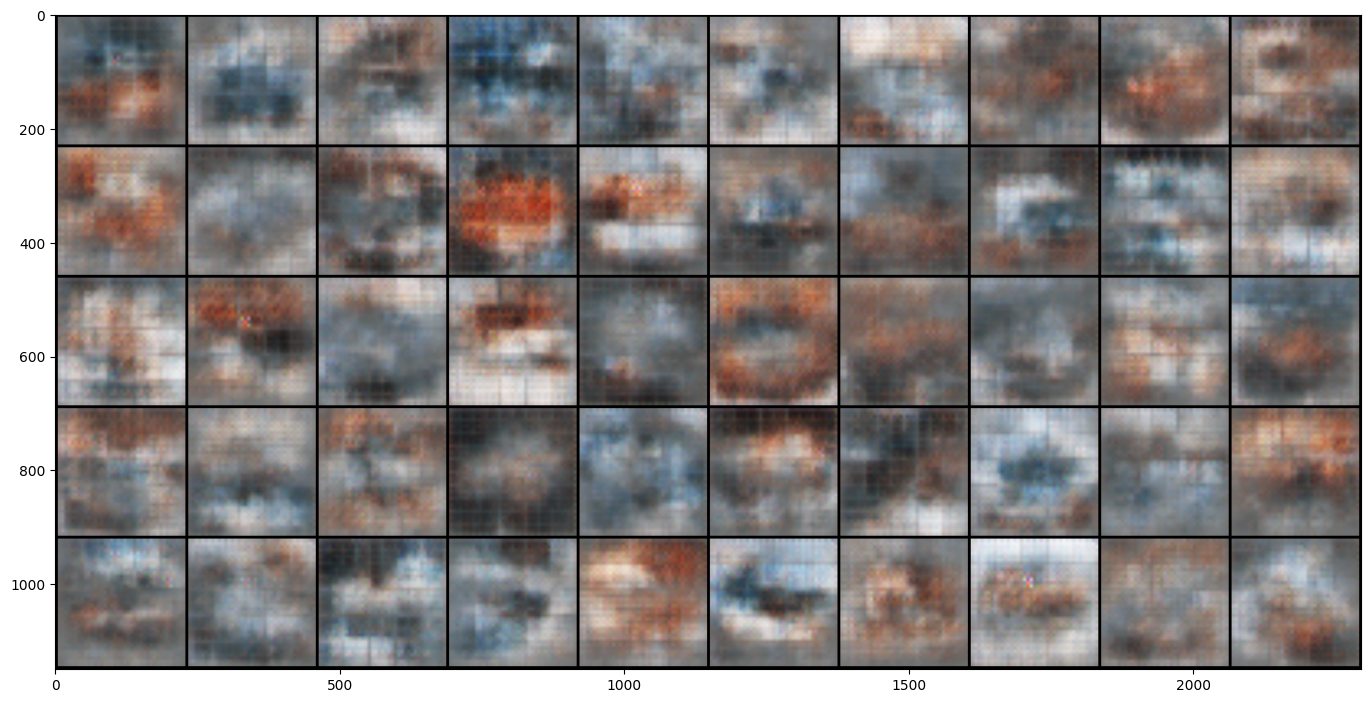

In [ ]:
def show_image(img):
    npimg = img.numpy()
    #  transposes the dimensions of the NumPy array to convert it from a PyTorch tensor format (C, H, W) to a Matplotlib format (H, W, C)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# sets the VAE model to evaluation mode
resnet_vae.eval()

#  temporarily disable gradient computation
with torch.no_grad():

    # sample latent vectors from the normal distribution
    # 100 random latent vectors are sampled from a standard normal distribution
    # These latent vectors will be used to generate reconstructed images
    latent = torch.randn(50, CNN_embed_dim, device=device)

    # reconstruct images from the latent vectors
    img_recon = resnet_vae.decode(latent)
    # After generating the reconstructed images, the data is moved to the CPU. This is often done for compatibility with Matplotlib for visualization.
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon.data[:50],10,5))
    plt.show()

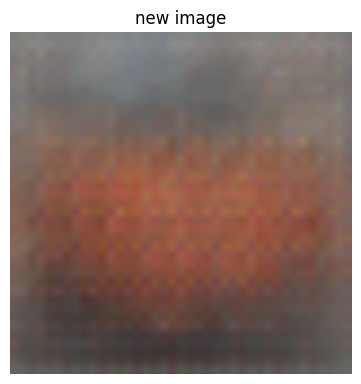

In [ ]:
# choose two original images
sample1, sample2 = 0, 1
w = 0.4 # weight for fusing two images

def decoder(model, device, z):
    model.eval()
    z = Variable(torch.FloatTensor(z)).to(device)
    new_images = model.decode(z).squeeze_().data.cpu().numpy().transpose((1, 2, 0))
    return new_images

exp = 'cifar10'

# generate image using decoder using two generated results during the trianing process
saved_model_path = './results_cifar10'
z_train = np.load(os.path.join(saved_model_path, 'z_train_epoch{}.npy').format(epoch))
z = z_train[-sample1] * w + z_train[-sample2] * (1 - w)
new_imgs = decoder(resnet_vae, device, torch.from_numpy(z).view(1, -1))

fig = plt.figure(figsize=(15, 15))

plt.subplot(1, 3, 3)
plt.imshow(new_imgs)
plt.title('new image')
plt.axis('off')
plt.savefig("./generated_{}.png".format(exp), bbox_inches='tight', dpi=600)
plt.show()

# Reference
- https://www.kaggle.com/code/speedwagon/variational-autoencoder-dogs-generation
- https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-understanding-kl-divergence-2b382ca2b2a8
- https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f
- https://avandekleut.github.io/vae/
- https://towardsdatascience.com/variational-autoencoder-demystified-with-pytorch-implementation-3a06bee395ed